# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [149]:
# imports
import numpy as np
from random import randint
import pandas as pd
import tensorflow as tf

In [150]:
# Load pickled data
import pickle
import sys
print(sys.version)
# TODO: Fill this in based on where you saved the training and testing data

training_file = './traffic-signs-data/train.p'
testing_file = './traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

# Create validation set, 30% training set
from sklearn.model_selection import train_test_split
X_train, X_validation, y_train, y_validation = train_test_split(train['features'], train['labels'], test_size=0.3, random_state=42)
X_test, y_test = test['features'], test['labels']

3.5.2 |Continuum Analytics, Inc.| (default, Jul  2 2016, 17:53:06) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [151]:
### Replace each question mark with the appropriate value.

# TODO: Number of training examples
n_train = X_train.shape[0]

# TODO: Number of testing examples.
n_test = X_test.shape[0]

# TODO: What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 27446
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

In [152]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

In [153]:
# load csv
SignNames = pd.read_csv('./signnames.csv')
# print(SignNames.head())

Training:  (27446, 32, 32, 3) (27446,)
Testing:  (12630, 32, 32, 3) (12630,)
Validation:  (11763, 32, 32, 3) (11763,)


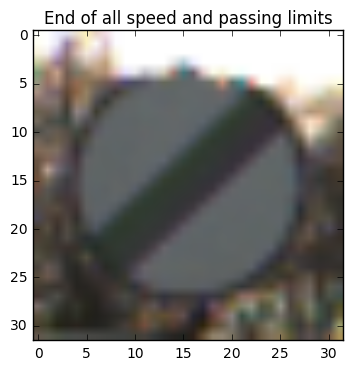

In [209]:
# quick recap on shapes
print('Training: ', X_train.shape, y_train.shape)
print('Testing: ', X_test.shape, y_test.shape)
print('Validation: ', X_validation.shape, y_validation.shape)
# visualize a few pictures
idx = randint(0,len(X_train) - 1)
plt.imshow(X_train[idx])
# show sign name
SignName = SignNames[SignNames['ClassId'] == y_train[idx]]['SignName'].values[0]
plt.title(SignName)
## tried some combinations, seems labels are accurate

<Container object of 43 artists>

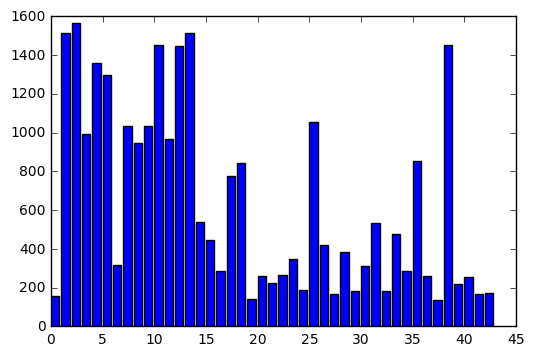

In [156]:
# test if label distribution balanced
unique, unique_counts = np.unique(y_train, return_counts=True)
plt.bar(unique, unique_counts)

## hmm, seems not very balanced, we might need to make sure minority labels have enough training sets latter

In [9]:
## Generate more image samples by rotating, shearing, translating, augmenting brightness of a picture
## This code is stolen from Vivek Yadav, because I'm lazy ;p
## Link: https://github.com/vxy10/ImageAugmentation
import matplotlib.gridspec as gridspec
import cv2
import matplotlib.image as mpimg

def augment_brightness_camera_images(image):
    image1 = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    random_bright = .25+np.random.uniform()
    #print(random_bright)
    image1[:,:,2] = image1[:,:,2]*random_bright
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
    return image1

def transform_image(img,ang_range=20,shear_range=10,trans_range=5,brightness=0):
    '''
    This function transforms images to generate new images.
    The function takes in following arguments,
    1- Image
    2- ang_range: Range of angles for rotation
    3- shear_range: Range of values to apply affine transform to
    4- trans_range: Range of values to apply translations over.

    A Random uniform distribution is used to generate different parameters for transformation

    '''
    # Rotation
    ang_rot = np.random.uniform(ang_range)-ang_range/2
    rows,cols,ch = img.shape    
    Rot_M = cv2.getRotationMatrix2D((cols/2,rows/2),ang_rot,1)

    # Translation
    tr_x = trans_range*np.random.uniform()-trans_range/2
    tr_y = trans_range*np.random.uniform()-trans_range/2
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])

    # Shear
    pts1 = np.float32([[5,5],[20,5],[5,20]])

    pt1 = 5+shear_range*np.random.uniform()-shear_range/2
    pt2 = 20+shear_range*np.random.uniform()-shear_range/2

    # Brightness
    pts2 = np.float32([[pt1,5],[pt2,pt1],[5,pt2]])

    shear_M = cv2.getAffineTransform(pts1,pts2)

    img = cv2.warpAffine(img,Rot_M,(cols,rows))
    img = cv2.warpAffine(img,Trans_M,(cols,rows))
    img = cv2.warpAffine(img,shear_M,(cols,rows))

    if brightness == 1:
      img = augment_brightness_camera_images(img)

    return img

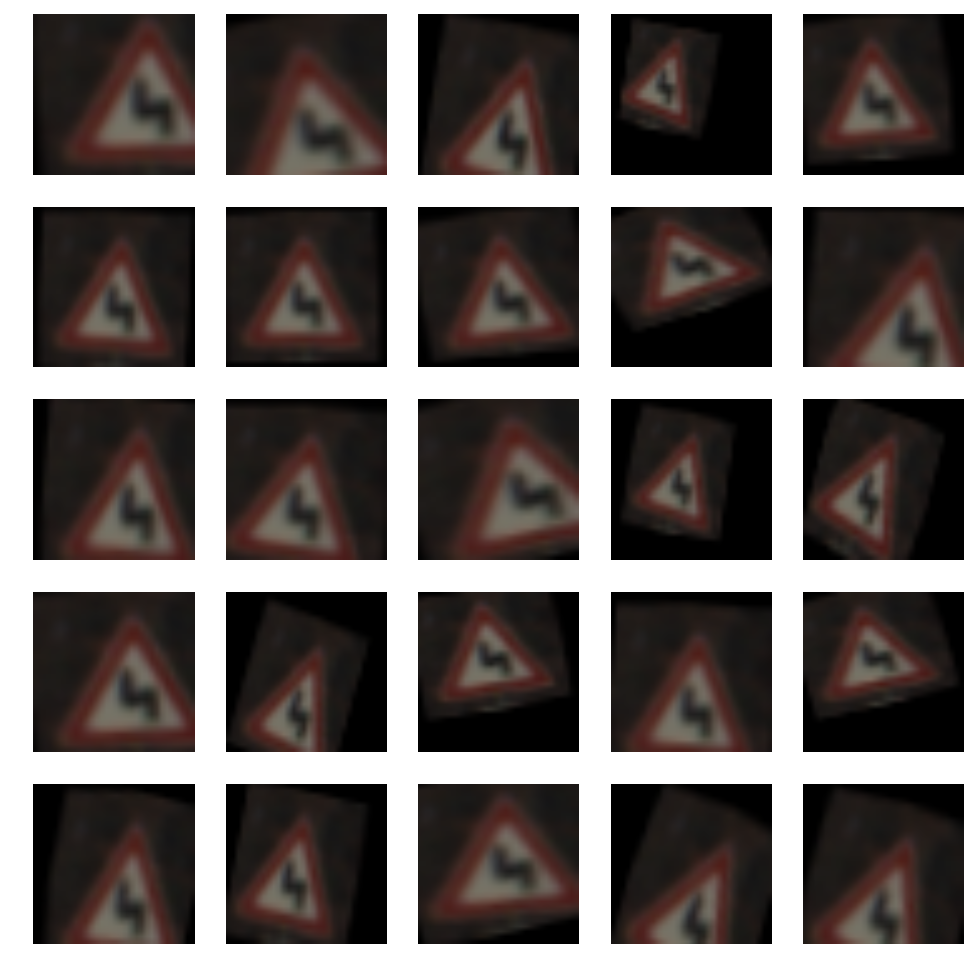

In [10]:
## examine the results
gs1 = gridspec.GridSpec(5, 5)
gs1.update(wspace=0.005, hspace=0.01) # set the spacing between axes.
plt.figure(figsize=(12,12))
for i in range(25):
    ax1 = plt.subplot(gs1[i])
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_aspect('equal')
    img = transform_image(X_train[0])

    plt.subplot(5,5,i+1)
    plt.imshow(img)
    plt.axis('off')

In [11]:
## create jittered images, fill each lable with 5000 samples for training
from sklearn.utils import resample
traget_samples = 5000
for label, count in enumerate(unique_counts):
    to_be_generated = traget_samples - count
    
    X_sample, y_sample = resample(X_train[y_train == label], y_train[y_train == label], n_samples=to_be_generated, random_state=42)

    X_jittered = np.zeros_like(X_sample)
    # apply transform on each image
    for idx, image in enumerate(X_sample):
        X_jittered[idx] = transform_image(image)
        
    X_train = np.concatenate((X_train,X_jittered))
    y_train = np.concatenate((y_train, y_sample))


print(X_train.shape)
print(y_train.shape)

(215000, 32, 32, 3)
(215000,)


37583


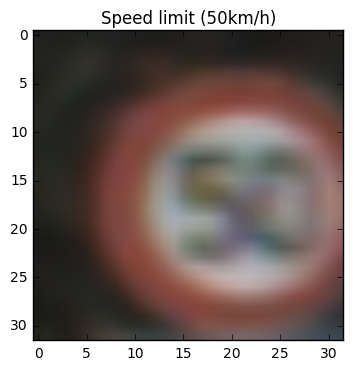

In [12]:
# visualize sythetic pictures
idx = randint(n_train,len(X_train) - 1)
print(idx)
plt.imshow(X_train[idx])
# show sign name
SignName = SignNames[SignNames['ClassId'] == y_train[idx]]['SignName'].values[0]
plt.title(SignName)

In [13]:
# shuffle training set
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train, random_state=42)

<Container object of 43 artists>

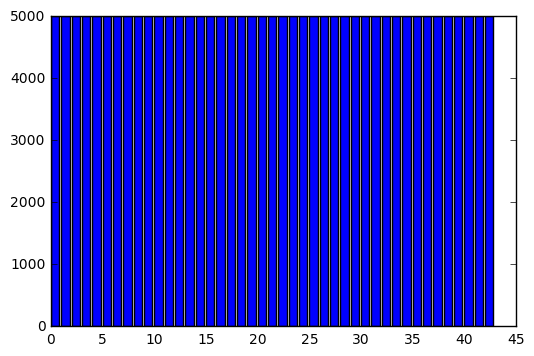

In [14]:
# test if label distribution balanced now
unique, unique_counts = np.unique(y_train, return_counts=True)
plt.bar(unique, unique_counts)

In [112]:
## preprocessing: turn color image to black and white
## idea stolen from Yann lecun
## code stolen from http://navoshta.com/traffic-signs-classification/
from skimage import exposure

def gray_scale(X):
    #Convert to grayscale, e.g. single Y channel
    X = 0.299 * X[:, :, :, 0] + 0.587 * X[:, :, :, 1] + 0.114 * X[:, :, :, 2]
    #Scale features to be in [0, 1]
    X = (X / 255.).astype(np.float32)

    # Apply localized histogram localization
    for i in range(X.shape[0]):
        X[i] = exposure.equalize_adapthist(X[i])

    # Add a single grayscale channel
    X = X.reshape(X.shape + (1,)) 
    return X

In [ ]:
X_train = gray_scale(X_train)
X_validation = gray_scale(X_validation)
X_test = gray_scale(X_test)

In [22]:
print(X_test.shape)

(12630, 32, 32, 1)


82078


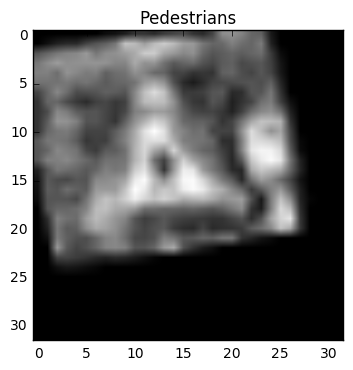

In [23]:
## show gray scale image
idx = randint(n_train,len(X_train) - 1)
print(idx)
plt.imshow(X_train[idx].squeeze(), cmap='gray')
# show sign name
SignName = SignNames[SignNames['ClassId'] == y_train[idx]]['SignName'].values[0]
plt.title(SignName)

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [24]:
### Shuffle data
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train)

In [102]:
from tensorflow.contrib.layers import flatten

# Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
mu = 0
sigma = 0.1
conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 32), mean = mu, stddev = sigma))
conv1_b = tf.Variable(tf.zeros(32))
conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 32, 64), mean = mu, stddev = sigma))
conv2_b = tf.Variable(tf.zeros(64))
fc1_W = tf.Variable(tf.truncated_normal(shape=(7872, 1024), mean = mu, stddev = sigma))
fc1_b = tf.Variable(tf.zeros(1024))
fc2_W  = tf.Variable(tf.truncated_normal(shape=(1024, 1024), mean = mu, stddev = sigma))
fc2_b  = tf.Variable(tf.zeros(1024))
fc3_W  = tf.Variable(tf.truncated_normal(shape=(1024, 43), mean = mu, stddev = sigma))
fc3_b  = tf.Variable(tf.zeros(43))

def LeNet(x):    
    
    # SOLUTION: Layer 1: Convolutional. input 32,32,1, output 28,28,32
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b
    
    # SOLUTION: Activation.
    conv1 = tf.nn.relu(conv1)

    # SOLUTION: Pooling. input 28,28,32, output 14, 14, 32
    pool1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    # Dropout
    tf.nn.dropout(pool1, .5)
    
    # SOLUTION: Layer 2: Convolutional. input 14,14,32, output 10, 10, 64
    conv2   = tf.nn.conv2d(pool1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # SOLUTION: Activation.
    conv2 = tf.nn.relu(conv2)

    # SOLUTION: Pooling. input 10, 10, 64, output 5,5,64
    pool2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Dropout
    tf.nn.dropout(pool2, .5)
    # SOLUTION: Flatten. input 5,5,64 + 14,14,32, output 1600 + 6272 = 7872
    fc0   = tf.concat(1, [flatten(pool2), flatten(pool1)])
    # Relu
    tf.nn.relu(fc0)
    # Dropout
    tf.nn.dropout(fc0, .5)
    
    # SOLUTION: Layer 3: Fully Connected. input 7872, output 1024
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    # SOLUTION: Activation.
    fc1    = tf.nn.relu(fc1)
    # Dropout
    tf.nn.dropout(fc1, .5)
    
    # SOLUTION: Layer 4: Fully Connected. input 1024, output 1024
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # SOLUTION: Activation.
    fc2    = tf.nn.relu(fc2)
    # Dropout
    tf.nn.dropout(fc2, .5)
    
    # SOLUTION: Layer 5: Fully Connected. input 1024, output 43
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    # Dropout
    tf.nn.dropout(logits, .5) 
    
    return logits

In [26]:
### Training

EPOCHS = 1000
BATCH_SIZE = 128

x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

rate = 1e-4
lamda = 1e-5

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
## L2 regularization for weights
l2_loss = lamda * (tf.nn.l2_loss(conv1_W) + tf.nn.l2_loss(conv2_W) + tf.nn.l2_loss(fc1_W) + tf.nn.l2_loss(fc2_W) + tf.nn.l2_loss(fc3_W))
loss_operation = tf.reduce_mean(cross_entropy + l2_loss)

optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    train_acc_list = []
    validation_acc_list = []
    

    max_accuracy = .0
    non_improve_counter = 0
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        mini_batch_accuracy = evaluate(batch_x, batch_y)
        validation_accuracy = evaluate(X_validation, y_validation)

        train_acc_list.append(mini_batch_accuracy)
        validation_acc_list.append(validation_accuracy)
        print("EPOCH {} ...".format(i+1))
        print("Training accuracy = {:.3f}, Validation Accuracy = {:.3f}".format(mini_batch_accuracy, validation_accuracy))
        print()
        
        if validation_accuracy > max_accuracy:
            max_accuracy = validation_accuracy
            non_improve_counter = 0
        else:
            non_improve_counter += 1
        
        # early stop if accuracy does not improve in 100 epochs
        if non_improve_counter > 100:
            print("Early stop at epoch {}".format(i))
            break
        
    saver.save(sess, './lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Training accuracy = 0.625, Validation Accuracy = 0.857

EPOCH 2 ...
Training accuracy = 0.818, Validation Accuracy = 0.921

EPOCH 3 ...
Training accuracy = 0.875, Validation Accuracy = 0.961

EPOCH 4 ...
Training accuracy = 0.920, Validation Accuracy = 0.971

EPOCH 5 ...
Training accuracy = 0.966, Validation Accuracy = 0.978

EPOCH 6 ...
Training accuracy = 0.977, Validation Accuracy = 0.978

EPOCH 7 ...
Training accuracy = 1.000, Validation Accuracy = 0.984

EPOCH 8 ...
Training accuracy = 0.966, Validation Accuracy = 0.985

EPOCH 9 ...
Training accuracy = 1.000, Validation Accuracy = 0.987

EPOCH 10 ...
Training accuracy = 1.000, Validation Accuracy = 0.986

EPOCH 11 ...
Training accuracy = 1.000, Validation Accuracy = 0.990

EPOCH 12 ...
Training accuracy = 1.000, Validation Accuracy = 0.988

EPOCH 13 ...
Training accuracy = 1.000, Validation Accuracy = 0.986

EPOCH 14 ...
Training accuracy = 1.000, Validation Accuracy = 0.991

EPOCH 15 ...
Training accuracy

In [105]:
with tf.Session() as sess:
    new_saver = tf.train.import_meta_graph('./lenet.meta')
    new_saver.restore(sess, tf.train.latest_checkpoint('.'))
    
    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.974


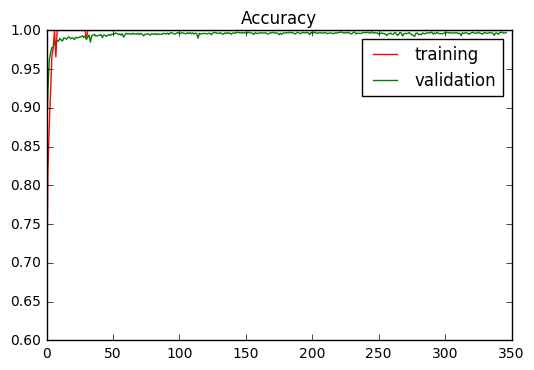

In [93]:
plt.plot(np.arange(len(train_acc_list)), train_acc_list, 'r', np.arange(len(validation_acc_list)), validation_acc_list, 'g')
plt.title("Accuracy")
plt.legend(['training', 'validation'])

### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**
I've adopted 3 preprocessing techniques into my model.

1. Creating validation set. Validation set validate how well the model has trained on training set, after many times of validation, the model might infer some of the charactoristics of the validation set and overfit to the validation set. Therefore, Creating a dedicated validation set differs from training and testing dataset is needed.

2. Data augmentation. Since we are dealing with images, random modifications can be applied to the images to generate more images which are slightly different from the original. In this project I've applied roation, sheering, translation and augmenting brightness of the images. Further more, the training set distribution is balanced to give more reliable prediction in real life (no neccessarily for this test set though).

3. Convert images to gray scale. According to Pierre Sermanet et. al. http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf, convert images GTSRB images to gray scale will improve the accuracy and efficiency of the model.



### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

1. Create validation set by splitting 30% training set.
2. Augmenting training set, balance class distribution with augmented images
    - Rotation 0~20 degrees
    - Shearing 0~10 degrees
    - Translation 0~5 degrees
    - Augmenting image brightness 25-125%

Generating augmented images is a cheap way to get more data, help model to generalize then make better predictions. By balancing lable distribution with jittered images, model is less likely to overfit on the given distribution.
3. Preprocess training, validation, testing data set into gray scale image

Research have shown that gray scale images for this dataset performs better on the model

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

Model architecture is illustrated below

![title](network_structure.png)

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**
Optimizer: AdamOptimizer

Batch size: 128

Epochs: 1000 epochs, with early stop if performance does not improve in 100 epochs; actual number of epochs is 346

Learning rate: 1e-4

L2 regularization lamda: 1e-5



### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

My general approach is to find the best practice in literature, adopt each technique then compare the performance gain. 

The general roadmap is: Origin -> Add data Augmentation -> Tuning parameter -> Adjust network structure -> Tuning parameter -> Add preprocessing -> Tuning parameter. 

There are 3 well known implementations that I adopted. 

1. Data augmentation, provide more variations of training set to help model to generalize. 
2. Enhance model structure, increase number of filters in convolution to abtain more information; multi-scale architecture to help neural net to abstract patterns.
3. Preprocessing, convert images to gray scale helps model to converge.

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

I've downloaded some UK traffic signs from here: https://www.gov.uk/guidance/the-highway-code/traffic-signs

Their graph and meaning is visualized below.

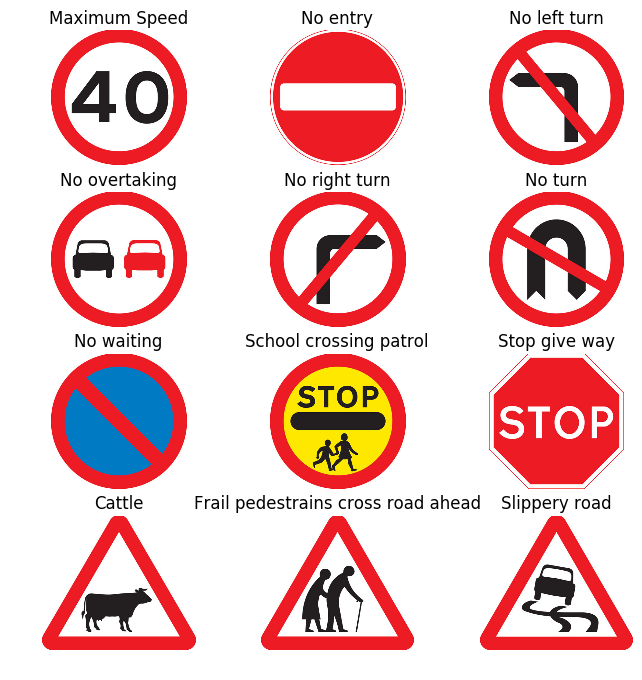

In [135]:

import skimage.io as io
coll = io.imread_collection('./new-signs/*.jpg')
names = ['Maximum Speed', 'No entry', 'No left turn', 'No overtaking', 'No right turn', 'No turn', 'No waiting', 'School crossing patrol', 'Stop give way', 'Cattle', 'Frail pedestrains cross road ahead', 'Slippery road']
## examine the results
gs1 = gridspec.GridSpec(4, 3)
gs1.update(wspace=0.005, hspace=0.01) # set the spacing between axes.
plt.figure(figsize=(8,8))
for i in range(12):
    ax1 = plt.subplot(gs1[i])
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_aspect('equal')
    plt.subplot(4,3,i+1)
    plt.imshow(coll[i])
    plt.title(names[i])
    plt.axis('off')

In [113]:
## preprocess images before feed into neural network
from skimage.transform import resize
images_resize = np.zeros((len(coll), 32, 32, 3))

for i, img in enumerate(coll):
    images_resize[i] = resize(img, (32, 32))


images_feed = gray_scale(images_resize)

/home/liangyuan/anaconda2/envs/tf3/lib/python3.5/site-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float32 to uint16
  "%s to %s" % (dtypeobj_in, dtypeobj))


In [ ]:
# # examine the results
# gs1 = gridspec.GridSpec(4, 3)
# gs1.update(wspace=0.005, hspace=0.01) # set the spacing between axes.
# plt.figure(figsize=(12,12))
# for i in range(12):
#     ax1 = plt.subplot(gs1[i])
#     ax1.set_xticklabels([])
#     ax1.set_yticklabels([])
#     ax1.set_aspect('equal')
#     plt.title(names[i])
#     plt.subplot(4,3,i+1)
#     plt.imshow(images_feed[i].squeeze(), cmap='gray')
#     plt.axis('off')

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:** I've visualized the prediction and their respective probabilities below.

In general, the neural network performs good on witnessed traffic signs and poor on novel signs.

Some guesses made by the model is quite close, such as the UK 40 maximum speed is predicted as speed limit 60km/h. Some are very far off such as the UK slippery road is predicted as dangerous curve to the left. Interestingly due to left hand traffic in UK, the model completely failed to predict No turn.

In [107]:

with tf.Session() as sess:
    new_saver = tf.train.import_meta_graph('./lenet.meta')
    new_saver.restore(sess, tf.train.latest_checkpoint('.'))
    softmax = tf.nn.softmax(logits)
    top_k_val, top_k_idx = tf.nn.top_k(softmax, k=5)
    
    top_k_vals, top_k_idxs = sess.run([top_k_val, top_k_idx], feed_dict={x: images_feed})

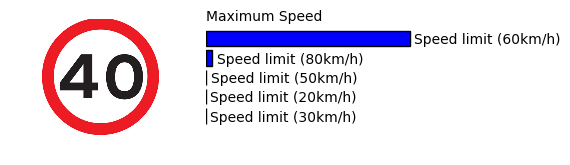

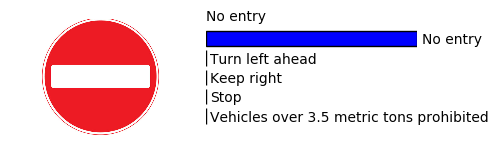

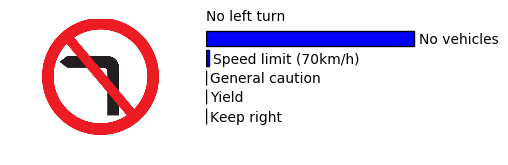

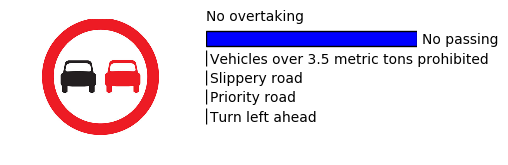

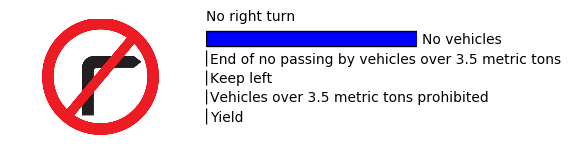

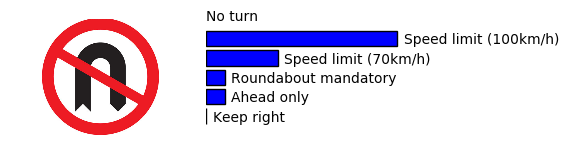

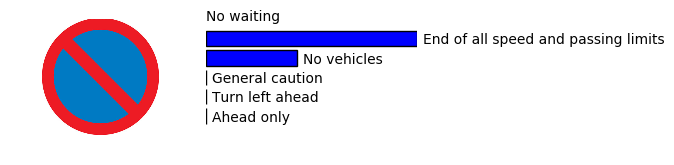

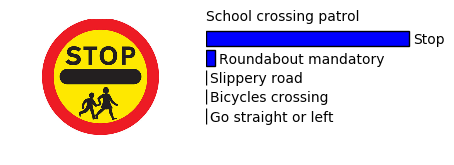

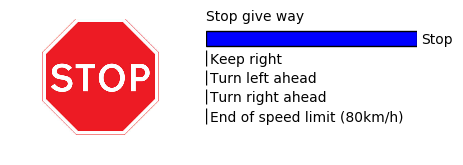

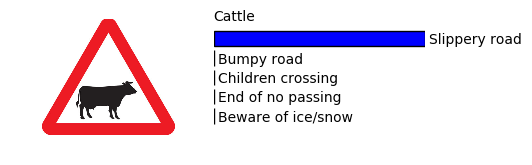

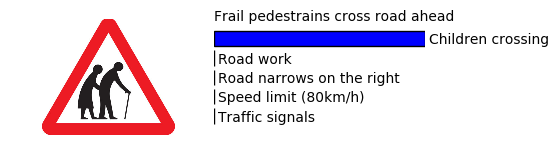

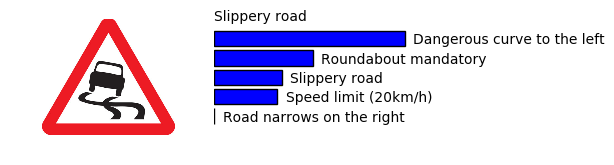

In [136]:
for i in range(12):
    plt.figure(figsize = (5,1.5))
    gs = gridspec.GridSpec(1, 2, width_ratios=[2,3])
    plt.subplot(gs[0])
    plt.imshow(coll[i])
    plt.axis('off')
    plt.subplot(gs[1])
    plt.barh(6-np.arange(5),top_k_vals[i], align='center')
    for i_label in range(5):
        plt.text(top_k_vals[i][i_label]+.02,6-i_label-.25,
            SignNames[SignNames['ClassId'] == top_k_idxs[i][i_label]]['SignName'].values[0])
    plt.axis('off')
    plt.text(0,6.95,names[i])
    plt.show()

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:** The model has an accuracy of 3/12=25%. Pretty bad compared to the testing dataset.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:** The model are more certain on similar signs and less certain on novel signs. For most the time, even if the sign layout is quite different, the model is able to give the correct predictions in top 5.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.